In [22]:
import numpy as np
import matplotlib.pyplot as plt



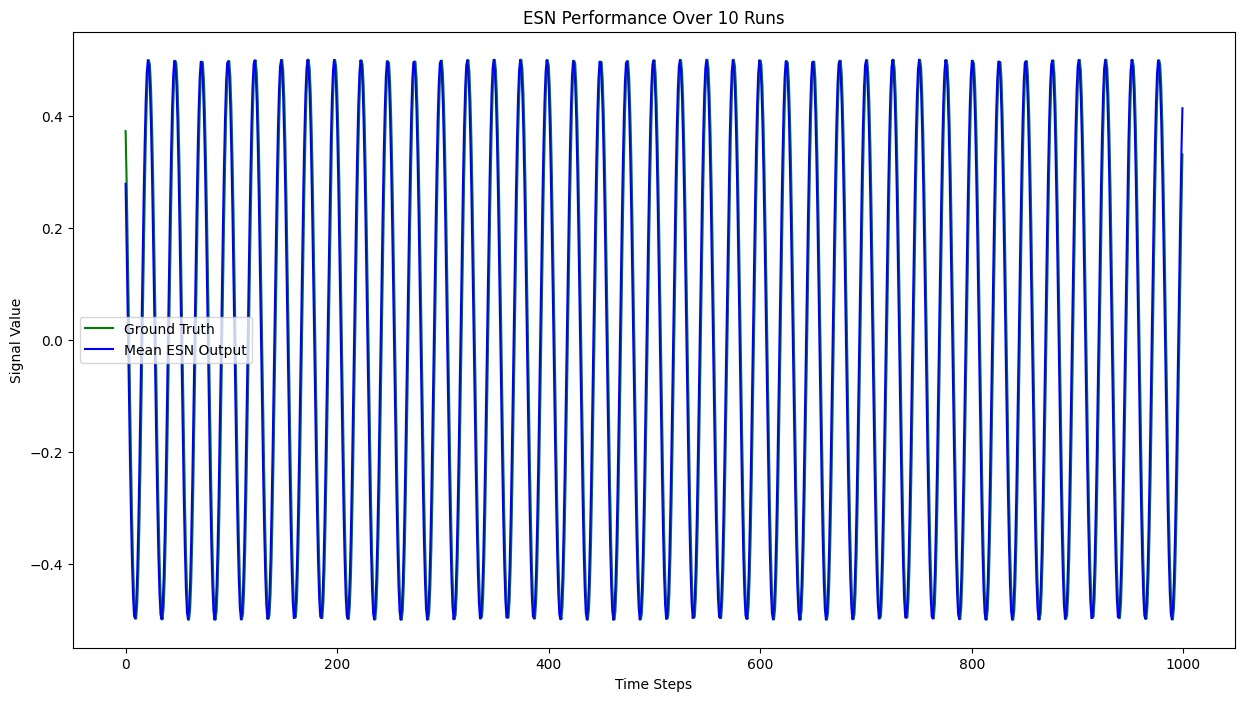

In [21]:
# Optimized implementation to reduce execution time

# Parameters
N = 1000  # number of neurons in the reservoir
spectral_radius = 0.8
input_scaling = 0.2
train_len = 3000
test_len = 1000
init_len = 1000
runs = 10  # number of independent runs

# Generate the data
time = np.arange(0, train_len + test_len, 1)
data = 0.5 * np.sin(time / 4)

# Placeholder for predictions from all runs
all_predictions = np.zeros((runs, test_len))

# Simplifying the reservoir initialization
for run in range(runs):
    Win = np.random.rand(N, 2) - 0.5
    Win *= input_scaling
    W = np.random.rand(N, N) - 0.5
    W *= spectral_radius / np.sqrt(N)  # Approximate normalization

    # Allocate memory for the design (collected states) matrix
    X = np.zeros((1 + N, train_len - init_len))
    # Set the corresponding target matrix directly
    Yt = data[None, init_len+1:train_len+1]

    # Run the reservoir with the data and collect X
    x = np.zeros((N, 1))
    for t in range(train_len):
        u = data[t]
        input_with_bias = np.vstack((1, u))
        x = (1 - spectral_radius) * x + spectral_radius * np.tanh(np.dot(Win, input_with_bias) + np.dot(W, x))
        if t >= init_len:
            X[:, t - init_len] = np.vstack((u, x))[:, 0]

    # Train the output by ridge regression
    reg = 1e-8  # regularization coefficient
    Wout = np.dot(np.dot(Yt, X.T), np.linalg.inv(np.dot(X, X.T) + reg * np.eye(1 + N)))

    # Run the trained ESN in generative mode for testing
    Y = np.zeros((test_len))
    u = data[train_len]
    for t in range(test_len):
        input_with_bias = np.vstack((1, u))
        x = (1 - spectral_radius) * x + spectral_radius * np.tanh(np.dot(Win, input_with_bias) + np.dot(W, x))
        y = np.dot(Wout, np.vstack((u, x)))
        Y[t] = y
        u = y

    all_predictions[run] = Y

# Calculate mean values of predictions from all runs
mean_predictions = np.mean(all_predictions, axis=0)

# Plotting the results
plt.figure(figsize=(15, 8))
plt.plot(data[train_len:train_len+test_len], 'g', label="Ground Truth")
plt.plot(mean_predictions, 'b', label="Mean ESN Output")
plt.title("ESN Performance Over 10 Runs")
plt.xlabel("Time Steps")
plt.ylabel("Signal Value")
plt.legend()
plt.show()


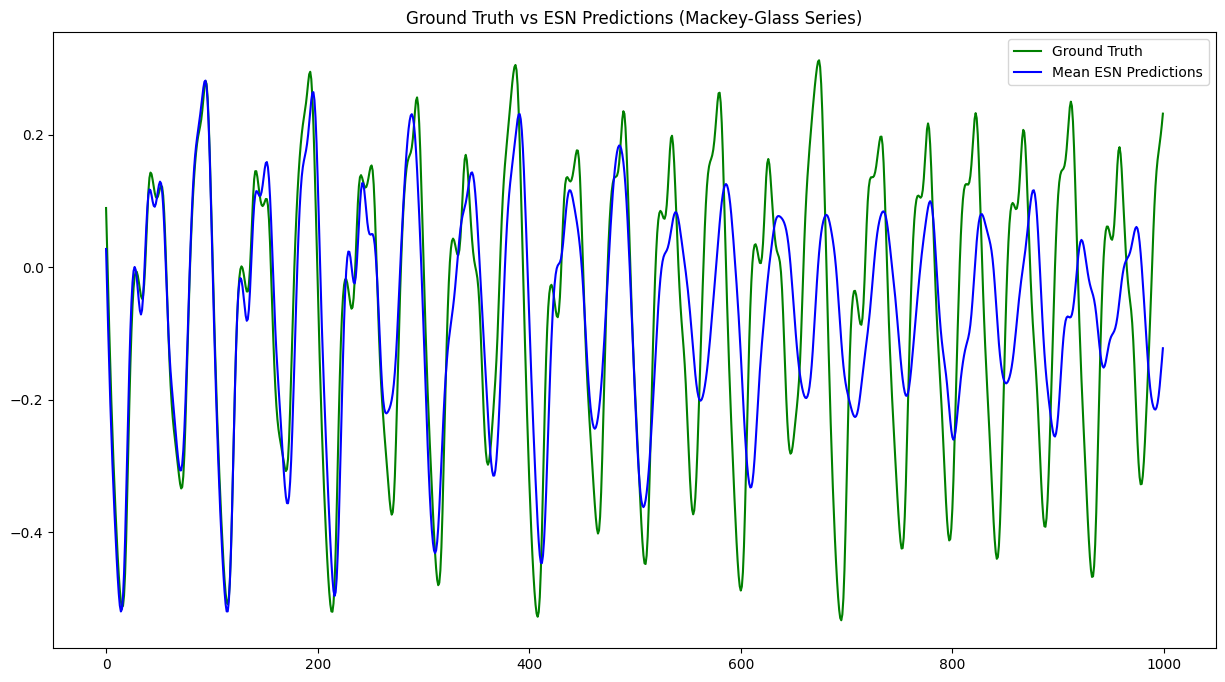

In [24]:
# Function to train and test the ESN
def train_and_test_ESN(data, train_len, test_len, init_len, N, spectral_radius, input_scaling, reg):
    # Initialize the reservoir
    Win = (np.random.rand(N, 2) - 0.5) * input_scaling
    W = np.random.rand(N, N) - 0.5
    rhoW = np.max(np.abs(np.linalg.eigvals(W)))
    W *= spectral_radius / rhoW

    # Prepare the design matrix
    X = np.zeros((1 + N, train_len - init_len))
    Yt = data[None, init_len+1:train_len+1]

    # Running the reservoir with the data
    x = np.zeros((N, 1))
    for t in range(train_len):
        u = data[t]
        input_with_bias = np.vstack((1, u))
        x = (1 - spectral_radius) * x + spectral_radius * np.tanh(np.dot(Win, input_with_bias) + np.dot(W, x))
        if t >= init_len:
            X[:, t - init_len] = np.vstack((u, x))[:, 0]

    # Train the output by ridge regression
    Wout = np.dot(np.dot(Yt, X.T), np.linalg.inv(np.dot(X, X.T) + reg * np.eye(1 + N)))

    # Testing the ESN
    Y = np.zeros((test_len))
    u = data[train_len]
    for t in range(test_len):
        input_with_bias = np.vstack((1, u))
        x = (1 - spectral_radius) * x + spectral_radius * np.tanh(np.dot(Win, input_with_bias) + np.dot(W, x))
        y = np.dot(Wout, np.vstack((u, x)))
        Y[t] = y
        u = y
    
    return Y

# Parameters
num_experiments = 10
predictions = np.zeros((num_experiments, test_len))

# Repeating the experiment
for i in range(num_experiments):
    predictions[i, :] = train_and_test_ESN(data, train_len, test_len, init_len, N, spectral_radius, input_scaling, reg)

# Calculating mean predictions
mean_predictions = np.mean(predictions, axis=0)

# Plotting the results
plt.figure(figsize=(15, 8))
plt.plot(data[train_len:train_len+test_len], 'g', label="Ground Truth")
plt.plot(mean_predictions, 'b', label="Mean ESN Predictions")
plt.title("Ground Truth vs ESN Predictions (Mackey-Glass Series)")
plt.legend()
plt.show()


In [ ]:
# 4 - Time Series Prediction with ESNs